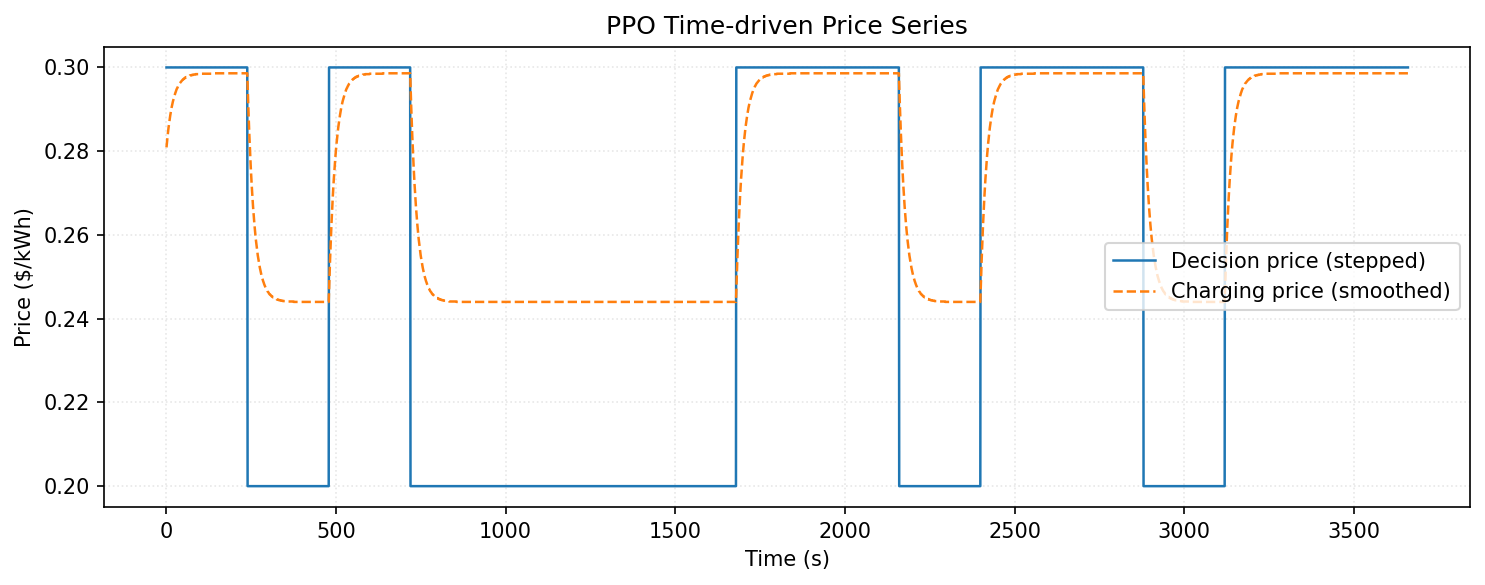

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

price_path = Path(r"C:\Users\曦曦yyds\Desktop\controlled_prices.csv")

df = pd.read_csv(price_path)

plt.figure(figsize=(10,4), dpi=150)
plt.plot(df["time_s"], df["decision_price_$per_kWh"], label="Decision price (stepped)", lw=1.2)
plt.plot(df["time_s"], df["charge_price_$per_kWh"], label="Charging price (smoothed)", lw=1.2, linestyle="--")

plt.title("PPO Time-driven Price Series")
plt.xlabel("Time (s)")
plt.ylabel("Price ($/kWh)")
plt.legend()
plt.grid(alpha=0.3, linestyle=":")
plt.tight_layout()
plt.savefig(r"C:\Users\曦曦yyds\Desktop\ppo_time_price_series.png", dpi=180)
plt.show()


Figures generated:
 - revenue_total: C:\Users\曦曦yyds\Desktop\sumo_compare_1_total_revenue.png
 - par: C:\Users\曦曦yyds\Desktop\sumo_compare_2_par_peak_to_avg.png
 - util_by_station: C:\Users\曦曦yyds\Desktop\sumo_compare_3_utilization_by_station.png
 - rev_by_station: C:\Users\曦曦yyds\Desktop\sumo_compare_4_revenue_by_station.png
 - all_in_one: C:\Users\曦曦yyds\Desktop\sumo_compare_all_in_one.png


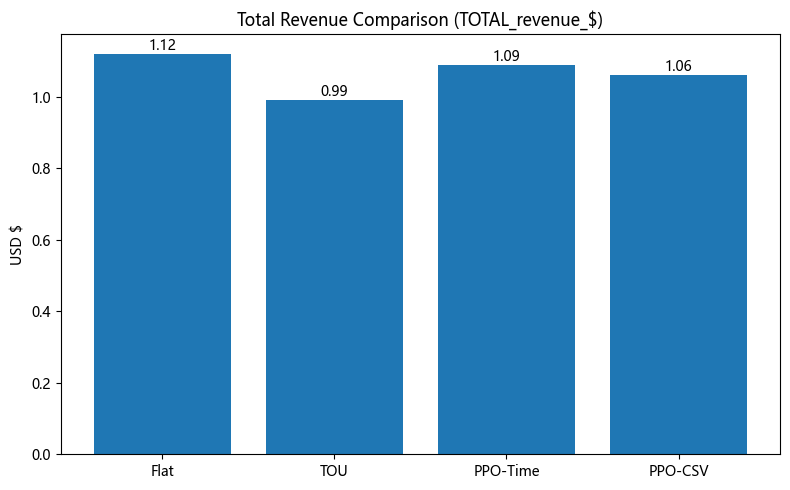

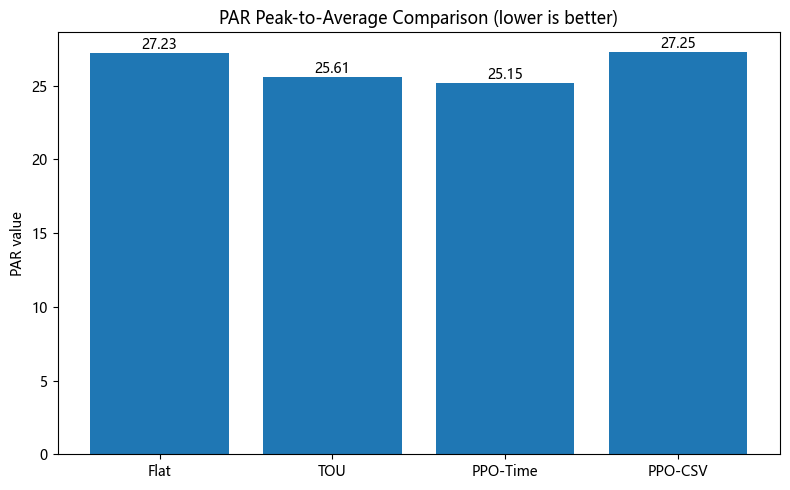

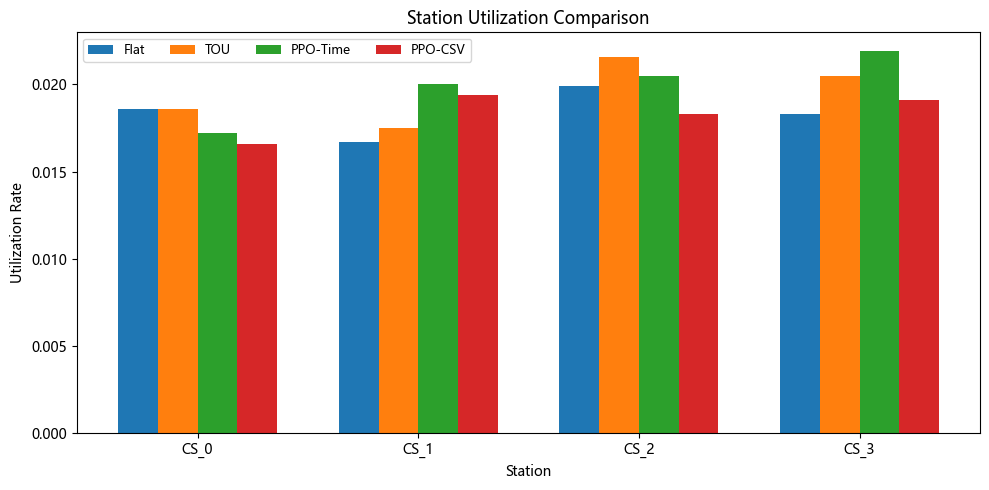

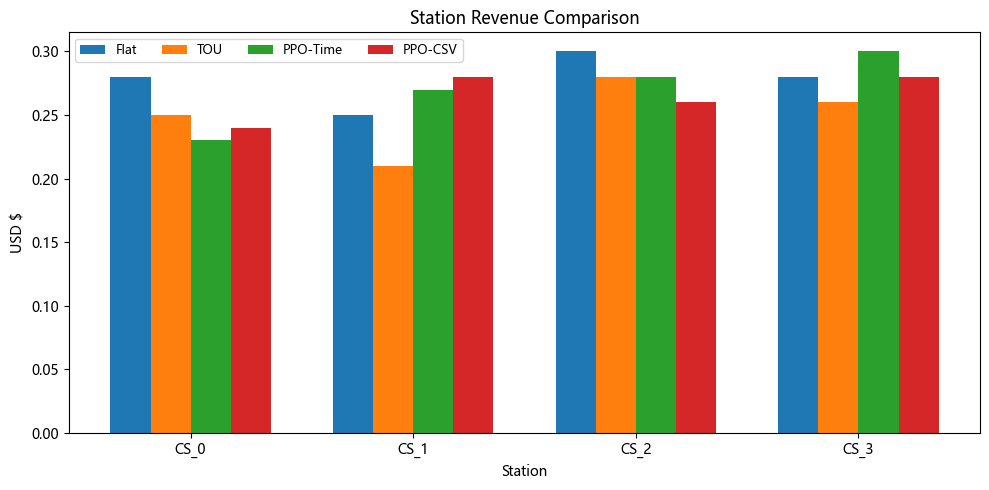

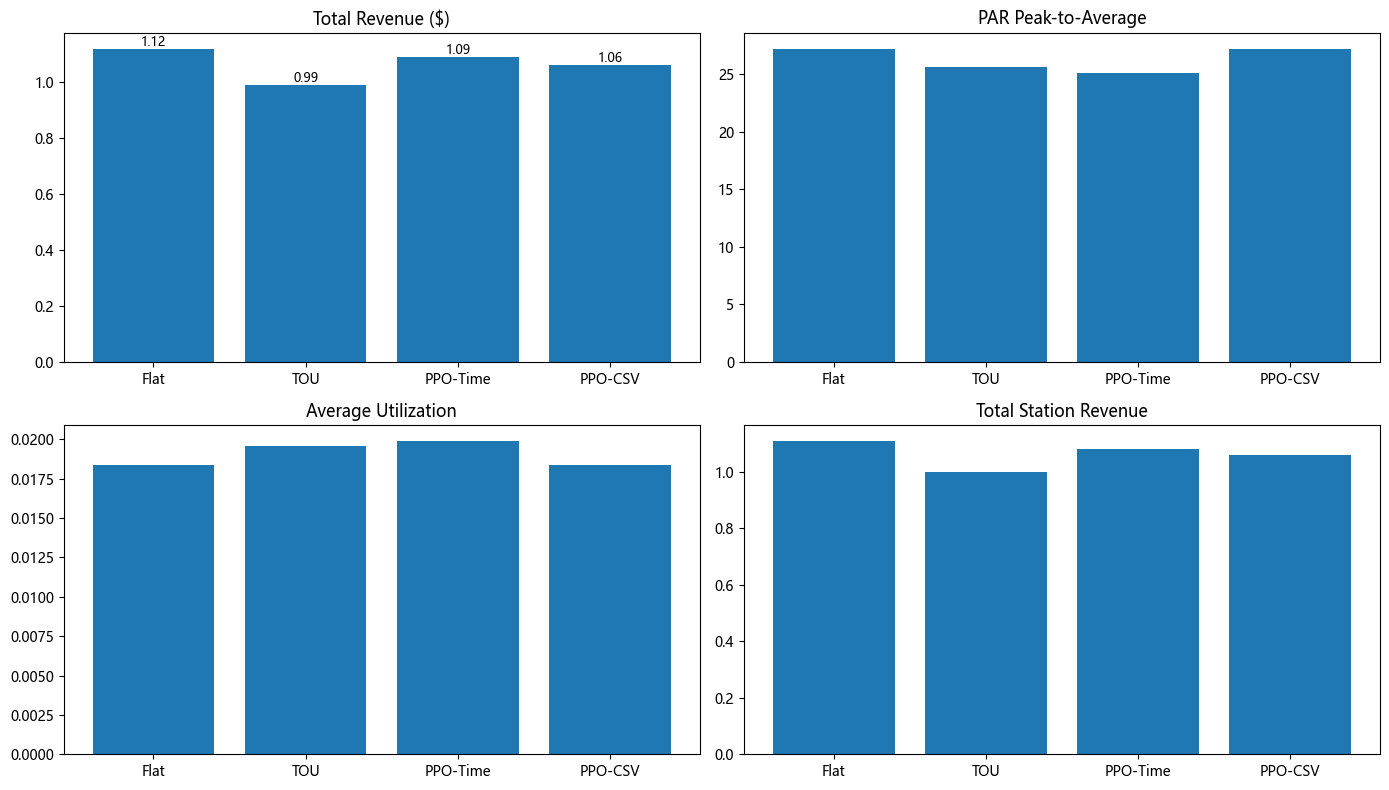

In [2]:
import os
import sys
from pathlib import Path
from typing import Dict, List, Tuple
import matplotlib.pyplot as plt
import pandas as pd


BASE = r"C:\Users\曦曦yyds\Desktop"

FILES = {
    "flat": os.path.join(BASE, "flat_2130_2230.csv"),
    "tou": os.path.join(BASE, "tou_2130_2230.csv"),
    "ppo_time": os.path.join(BASE, "ppo_time_valley.csv"),
    "ppo_csv": os.path.join(BASE, "ppo_csv_valley.csv"),
}

OUTPUTS = {
    "revenue_total": os.path.join(BASE, "sumo_compare_1_total_revenue.png"),
    "par": os.path.join(BASE, "sumo_compare_2_par_peak_to_avg.png"),
    "util_by_station": os.path.join(BASE, "sumo_compare_3_utilization_by_station.png"),
    "rev_by_station": os.path.join(BASE, "sumo_compare_4_revenue_by_station.png"),
    "all_in_one": os.path.join(BASE, "sumo_compare_all_in_one.png"),
}


def parse_strategy_file(path: str) -> Dict:
    """
    Read the CSV-like file and return a structured dictionary:
    {
        'meta': {key: value, ...},   # file header / parameters (e.g. base_$/kWh, period_s, etc.)
        'stations': pd.DataFrame(columns=['station_id','utilization_rate','revenue_$']),
        'summary': {'TOTAL_revenue_$': float, 'PAR_peak_to_avg_power': float, 'total_steps': int or None}
    }
    """
    meta: Dict[str, str] = {}
    stations: List[Tuple[str, float, float]] = []
    summary: Dict[str, float] = {}

    with open(path, 'r', encoding='utf-8-sig', errors='replace') as f:
        lines = [ln.strip() for ln in f.readlines()]

    # Locate the line index with station table header
    hdr_idx = None
    for i, ln in enumerate(lines):
        if ln.lower().startswith("station_id,utilization_rate,revenue_$"):
            hdr_idx = i
            break

    # helper function: parse key,value lines
    def try_kv(ln: str):
        if "," in ln and not ln.lower().startswith("station_id,"):
            k, v = ln.split(",", 1)
            return k.strip(), v.strip().strip('"')
        return None

    if hdr_idx is None:
        # No station table, treat all lines as key,value / summary
        for ln in lines:
            kv = try_kv(ln)
            if kv:
                k, v = kv
                if k in ("TOTAL_revenue_$", "PAR_peak_to_avg_power", "total_steps"):
                    summary[k] = _try_num(v)
                else:
                    meta[k] = v
    else:
        # Parse header section as meta
        for ln in lines[:hdr_idx]:
            if not ln or ln.startswith("#"):
                continue
            kv = try_kv(ln)
            if kv:
                k, v = kv
                meta[k] = v

        # Parse station table until empty line or summary key
        i = hdr_idx + 1
        while i < len(lines) and lines[i]:
            ln = lines[i]
            if any(ln.startswith(k + ",") for k in ("TOTAL_revenue_$", "PAR_peak_to_avg_power", "total_steps")):
                break
            parts = ln.split(",")
            if len(parts) >= 3:
                sid = parts[0].strip()
                util = _try_num(parts[1])
                rev = _try_num(parts[2])
                stations.append((sid, util, rev))
            i += 1

        # Parse summary section
        for ln in lines[i:]:
            if not ln:
                continue
            kv = try_kv(ln)
            if kv:
                k, v = kv
                if k in ("TOTAL_revenue_$", "PAR_peak_to_avg_power", "total_steps"):
                    summary[k] = _try_num(v)
                else:
                    meta[k] = v

    st_df = pd.DataFrame(stations, columns=["station_id", "utilization_rate", "revenue_$"])
    return {"meta": meta, "stations": st_df, "summary": summary}


def _try_num(s: str):
    try:
        if s is None or s == "":
            return None
        if s.isdigit():
            return int(s)
        return float(s)
    except Exception:
        return s


# -------- Load all strategy data --------
data = {}
missing = []
for name, path in FILES.items():
    if not os.path.exists(path):
        missing.append(path)
        continue
    data[name] = parse_strategy_file(path)

if missing:
    print("The following files were not found, please make sure they are placed on the Desktop with correct filenames:")
    for m in missing:
        print(" -", m)
    sys.exit(1)

# -------- Prepare summary data for comparison --------
strategies_order = ["flat", "tou", "ppo_time", "ppo_csv"]
strategy_labels = {
    "flat": "Flat",
    "tou": "TOU",
    "ppo_time": "PPO-Time",
    "ppo_csv": "PPO-CSV",
}

# (1) Total revenue
revenue_total = []
# (2) Peak-to-Average Ratio (PAR)
par_list = []

for s in strategies_order:
    sm = data[s]["summary"]
    revenue_total.append(sm.get("TOTAL_revenue_$", 0.0))
    par_list.append(sm.get("PAR_peak_to_avg_power", 0.0))

# (3) Station-level utilization and revenue
util_frames = []
rev_frames = []
for s in strategies_order:
    st = data[s]["stations"].copy()
    st["strategy"] = strategy_labels[s]
    util_frames.append(st[["station_id", "strategy", "utilization_rate"]])
    rev_frames.append(st[["station_id", "strategy", "revenue_$"]])

util_df = pd.concat(util_frames, ignore_index=True)
rev_df  = pd.concat(rev_frames, ignore_index=True)

# -------- Plotting --------
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei', 'SimHei', 'Arial']
plt.rcParams['axes.unicode_minus'] = False

# 1. Total revenue comparison
fig1, ax1 = plt.subplots(figsize=(8, 5))
ax1.bar([strategy_labels[s] for s in strategies_order], revenue_total)
ax1.set_title("Total Revenue Comparison (TOTAL_revenue_$)")
ax1.set_ylabel("USD $")
for i, v in enumerate(revenue_total):
    ax1.text(i, v, f"{v:.2f}", ha='center', va='bottom', fontsize=10)
fig1.tight_layout()
fig1.savefig(OUTPUTS["revenue_total"], dpi=200)

# 2. Peak-to-Average Ratio comparison
fig2, ax2 = plt.subplots(figsize=(8, 5))
ax2.bar([strategy_labels[s] for s in strategies_order], par_list)
ax2.set_title("PAR Peak-to-Average Comparison (lower is better)")
ax2.set_ylabel("PAR value")
for i, v in enumerate(par_list):
    ax2.text(i, v, f"{v:.2f}", ha='center', va='bottom', fontsize=10)
fig2.tight_layout()
fig2.savefig(OUTPUTS["par"], dpi=200)

# 3. Utilization by station (grouped bar chart)
stations_sorted = sorted(util_df["station_id"].unique(), key=lambda x: int(x.split("_")[-1]) if "_" in x and x.split("_")[-1].isdigit() else x)
strategies_lbl = [strategy_labels[s] for s in strategies_order]
import numpy as np
x = np.arange(len(stations_sorted))
width = 0.18

fig3, ax3 = plt.subplots(figsize=(10, 5))
for idx, s in enumerate(strategies_order):
    sub = util_df[util_df["strategy"] == strategy_labels[s]].set_index("station_id").reindex(stations_sorted)
    ax3.bar(x + (idx - 1.5) * width, sub["utilization_rate"].values, width, label=strategy_labels[s])
ax3.set_title("Station Utilization Comparison")
ax3.set_xlabel("Station")
ax3.set_ylabel("Utilization Rate")
ax3.set_xticks(x)
ax3.set_xticklabels(stations_sorted)
ax3.legend(ncol=4, fontsize=9)
fig3.tight_layout()
fig3.savefig(OUTPUTS["util_by_station"], dpi=200)

# 4. Revenue by station (grouped bar chart)
fig4, ax4 = plt.subplots(figsize=(10, 5))
for idx, s in enumerate(strategies_order):
    sub = rev_df[rev_df["strategy"] == strategy_labels[s]].set_index("station_id").reindex(stations_sorted)
    ax4.bar(x + (idx - 1.5) * width, sub["revenue_$"].values, width, label=strategy_labels[s])
ax4.set_title("Station Revenue Comparison")
ax4.set_xlabel("Station")
ax4.set_ylabel("USD $")
ax4.set_xticks(x)
ax4.set_xticklabels(stations_sorted)
ax4.legend(ncol=4, fontsize=9)
fig4.tight_layout()
fig4.savefig(OUTPUTS["rev_by_station"], dpi=200)

# 5. All-in-one summary (2x2 subplots)
fig, axs = plt.subplots(2, 2, figsize=(14, 8))

# Total revenue
axs[0,0].bar([strategy_labels[s] for s in strategies_order], revenue_total)
axs[0,0].set_title("Total Revenue ($)")
for i, v in enumerate(revenue_total):
    axs[0,0].text(i, v, f"{v:.2f}", ha='center', va='bottom', fontsize=9)

# PAR
axs[0,1].bar([strategy_labels[s] for s in strategies_order], par_list)
axs[0,1].set_title("PAR Peak-to-Average")

# Average utilization
util_mean = util_df.groupby("strategy")["utilization_rate"].mean().reindex(strategies_lbl).values
axs[1,0].bar(strategies_lbl, util_mean)
axs[1,0].set_title("Average Utilization")

# Total revenue by stations
rev_sum = rev_df.groupby("strategy")["revenue_$"].sum().reindex(strategies_lbl).values
axs[1,1].bar(strategies_lbl, rev_sum)
axs[1,1].set_title("Total Station Revenue")

for ax in axs.flat:
    ax.tick_params(axis='x', labelrotation=0)

fig.tight_layout()
fig.savefig(OUTPUTS["all_in_one"], dpi=200)

print("Figures generated:")
for k, p in OUTPUTS.items():
    print(f" - {k}: {p}")
